# Analyze Metal uptake

In [1]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [2]:
from coralme.builder.main import MEBuilder, MEReconstruction, METroubleshooter
from coralme.builder.curation import MECurator, MEManualCuration
from coralme.builder.helper_functions import flux_based_reactions,exchange_single_model
import coralme
import pickle
import pandas
import os
import tqdm
import numpy
import json
pandas.set_option('display.max_colwidth', None)
from coralme.builder.helper_functions import *
import matplotlib.pyplot as plt

## Analyze

In [3]:
with open('names.json') as f:
    names = json.load(f)

### Load models

In [4]:
def load_me(filename='me_model.pickle'):
    with open(filename, "rb") as f:
        return pickle.load(f)
    
def get_org_dirs(directory,files=False):
    if files:
        return [i for i in os.listdir(directory) if '.pkl' in i]
    return [i for i in os.listdir(directory) if os.path.isdir(directory+i) and '.' not in i and '_' not in i]

def run(i,directory,files=False,step=2,solve=False):
    if files:
        modelpath = directory + i
    elif step == 2:
        modelpath = directory + '{}/MEModel-step2-{}.pkl'.format(i,i)
    elif step == 3:
        modelpath = directory + '{}/MEModel-step3-{}-TS.pkl'.format(i,i)
    model = load_me(modelpath)
    if solve:
        model.optimize()
    return i.split(".pkl")[0], model

def load_models_from_directory(directory,solve=False, step = 2, files=False):
    d = {}
    dirs = get_org_dirs(directory,files=files)
    for org in tqdm.tqdm(dirs):
        args = [org,directory]
        kwds = {'files' : files, 'step' : step, 'solve' : solve}
        i,model = run(*args,**kwds)
        d[i] = model
    return d

In [5]:
models = {
#     'curated':load_models_from_directory('./published/',step=2),
    'clean':load_models_from_directory('./clean/',step=3)
         }

  0%|          | 0/21 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-16
Read LP format model from file /tmp/tmprk_z1vcj.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpd0ydtjq4.lp
Reading time = 0.00 seconds
: 952 rows, 2150 columns, 10008 nonzeros
Read LP format model from file /tmp/tmpoldu6ljq.lp
Reading time = 0.00 seconds
: 957 rows, 2144 columns, 9760 nonzeros


  5%|▍         | 1/21 [00:02<00:55,  2.79s/it]

Read LP format model from file /tmp/tmpwsvrbo3j.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp9io1lte_.lp
Reading time = 0.00 seconds
: 303 rows, 636 columns, 2922 nonzeros
Read LP format model from file /tmp/tmpwjca1vx0.lp
Reading time = 0.00 seconds
: 303 rows, 632 columns, 2910 nonzeros


 10%|▉         | 2/21 [00:03<00:27,  1.44s/it]

Read LP format model from file /tmp/tmphdj3ho8y.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpcdmatu2u.lp
Reading time = 0.01 seconds
: 1802 rows, 5090 columns, 19612 nonzeros
Read LP format model from file /tmp/tmpt54rtxsl.lp
Reading time = 0.01 seconds
: 1817 rows, 5084 columns, 19460 nonzeros


 14%|█▍        | 3/21 [00:08<00:59,  3.30s/it]

Read LP format model from file /tmp/tmpx9ntu_qw.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp_ag_o0u8.lp
Reading time = 0.00 seconds
: 888 rows, 2030 columns, 8878 nonzeros
Read LP format model from file /tmp/tmp12ggm7v0.lp
Reading time = 0.00 seconds
: 952 rows, 2024 columns, 8836 nonzeros


 19%|█▉        | 4/21 [00:11<00:55,  3.24s/it]

Read LP format model from file /tmp/tmprv2jspe7.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp_au_txlu.lp
Reading time = 0.01 seconds
: 1914 rows, 5238 columns, 19960 nonzeros
Read LP format model from file /tmp/tmpmioalols.lp
Reading time = 0.01 seconds
: 1912 rows, 5232 columns, 19796 nonzeros


 24%|██▍       | 5/21 [00:17<01:06,  4.15s/it]

Read LP format model from file /tmp/tmpw56n7aqq.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpafj0x67k.lp
Reading time = 0.00 seconds
: 768 rows, 1698 columns, 7642 nonzeros
Read LP format model from file /tmp/tmpnzawu5bd.lp
Reading time = 0.00 seconds
: 787 rows, 1692 columns, 7596 nonzeros


 29%|██▊       | 6/21 [00:19<00:50,  3.35s/it]

Read LP format model from file /tmp/tmpmcc7v6vg.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp_rrsurqw.lp
Reading time = 0.00 seconds
: 998 rows, 2452 columns, 11474 nonzeros
Read LP format model from file /tmp/tmp14a_e0v3.lp
Reading time = 0.00 seconds
: 999 rows, 2448 columns, 11252 nonzeros


 33%|███▎      | 7/21 [00:23<00:48,  3.47s/it]

Read LP format model from file /tmp/tmp_3cxgvgs.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmphsxzu50q.lp
Reading time = 0.00 seconds
: 1741 rows, 4344 columns, 15936 nonzeros
Read LP format model from file /tmp/tmpe7uxgdod.lp
Reading time = 0.00 seconds
: 1739 rows, 4340 columns, 15792 nonzeros


 38%|███▊      | 8/21 [00:28<00:51,  3.98s/it]

Read LP format model from file /tmp/tmpd4yt_31n.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp5w1ypaj8.lp
Reading time = 0.00 seconds
: 649 rows, 1508 columns, 6436 nonzeros
Read LP format model from file /tmp/tmpio95id4y.lp
Reading time = 0.00 seconds
: 651 rows, 1504 columns, 6386 nonzeros


 43%|████▎     | 9/21 [00:31<00:45,  3.80s/it]

Read LP format model from file /tmp/tmp816a4_om.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpydubxnue.lp
Reading time = 0.00 seconds
: 571 rows, 1304 columns, 5688 nonzeros
Read LP format model from file /tmp/tmpbh5vnyr7.lp
Reading time = 0.00 seconds
: 618 rows, 1300 columns, 5572 nonzeros


 48%|████▊     | 10/21 [00:32<00:33,  3.02s/it]

Read LP format model from file /tmp/tmparc1lyk9.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp4mmtqd79.lp
Reading time = 0.00 seconds
: 887 rows, 1784 columns, 7394 nonzeros
Read LP format model from file /tmp/tmptysfp07w.lp
Reading time = 0.00 seconds
: 892 rows, 1778 columns, 7256 nonzeros


 52%|█████▏    | 11/21 [00:34<00:25,  2.52s/it]

Read LP format model from file /tmp/tmp8ki4rcxb.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp063fffa_.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros
Read LP format model from file /tmp/tmpgqofdkgy.lp
Reading time = 0.01 seconds
: 2153 rows, 5848 columns, 23040 nonzeros


 57%|█████▋    | 12/21 [00:41<00:34,  3.85s/it]

Read LP format model from file /tmp/tmp9b_55qdn.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpeed9nh_2.lp
Reading time = 0.01 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /tmp/tmpn03sip6f.lp
Reading time = 0.01 seconds
: 1805 rows, 5160 columns, 20202 nonzeros


 62%|██████▏   | 13/21 [00:47<00:36,  4.61s/it]

Read LP format model from file /tmp/tmp54p09ohn.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpj2ldoenc.lp
Reading time = 0.00 seconds
: 1552 rows, 3922 columns, 14998 nonzeros
Read LP format model from file /tmp/tmpokqt0iyw.lp
Reading time = 0.00 seconds
: 1566 rows, 3918 columns, 14868 nonzeros


 67%|██████▋   | 14/21 [00:53<00:34,  4.89s/it]

Read LP format model from file /tmp/tmp0u3ju213.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpjzi5l013.lp
Reading time = 0.00 seconds
: 718 rows, 1632 columns, 7016 nonzeros
Read LP format model from file /tmp/tmpqe72w3o2.lp
Reading time = 0.00 seconds
: 729 rows, 1628 columns, 6842 nonzeros


 71%|███████▏  | 15/21 [00:54<00:23,  3.90s/it]

Read LP format model from file /tmp/tmpm_0_ya7q.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp2vs3u4ct.lp
Reading time = 0.00 seconds
: 1114 rows, 2298 columns, 10154 nonzeros
Read LP format model from file /tmp/tmpae4r66b6.lp
Reading time = 0.00 seconds
: 1116 rows, 2292 columns, 9972 nonzeros


 76%|███████▌  | 16/21 [00:56<00:16,  3.32s/it]

Read LP format model from file /tmp/tmpfu5pklf9.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp1b5fjbf3.lp
Reading time = 0.00 seconds
: 884 rows, 2458 columns, 10468 nonzeros
Read LP format model from file /tmp/tmpcd2w7o6f.lp
Reading time = 0.00 seconds
: 946 rows, 2452 columns, 10428 nonzeros


 81%|████████  | 17/21 [01:02<00:15,  3.91s/it]

Read LP format model from file /tmp/tmpy7_1k4ah.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpdkorme52.lp
Reading time = 0.00 seconds
: 485 rows, 1108 columns, 4628 nonzeros
Read LP format model from file /tmp/tmp51po793x.lp
Reading time = 0.00 seconds
: 539 rows, 1106 columns, 4516 nonzeros


 86%|████████▌ | 18/21 [01:02<00:09,  3.03s/it]

Read LP format model from file /tmp/tmpixzf1tkl.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpyy27f40t.lp
Reading time = 0.00 seconds
: 1335 rows, 2910 columns, 12048 nonzeros
Read LP format model from file /tmp/tmpt1ac6lak.lp
Reading time = 0.00 seconds
: 1369 rows, 2906 columns, 12024 nonzeros


 90%|█████████ | 19/21 [01:05<00:05,  2.89s/it]

Read LP format model from file /tmp/tmpdt10vb_8.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpf1lsmk19.lp
Reading time = 0.00 seconds
: 990 rows, 2500 columns, 10478 nonzeros
Read LP format model from file /tmp/tmpz9_4264w.lp
Reading time = 0.00 seconds
: 1055 rows, 2496 columns, 10342 nonzeros


 95%|█████████▌| 20/21 [01:07<00:02,  2.70s/it]

Read LP format model from file /tmp/tmpquymlodt.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp56lte_ew.lp
Reading time = 0.00 seconds
: 1109 rows, 2570 columns, 11714 nonzeros
Read LP format model from file /tmp/tmp5dyp4mr4.lp
Reading time = 0.00 seconds
: 1111 rows, 2564 columns, 11682 nonzeros


100%|██████████| 21/21 [01:14<00:00,  3.54s/it]


### Load

In [6]:
results_dict = {}
directory = "./analysis/10steps/"
for file in os.listdir(directory):
    if ".csv" not in file: continue
    results_dict[file.split("_C_")[0]] = pandas.read_csv(directory + file,index_col=0)

results_dict = {names[k]:v for k,v in results_dict.items()}

### Plot

In [7]:
def get_exchanges(org,metals):
    model = models["clean"][org]
    exchanges = ["^EX_{}.?e.?$".format(m) for m in metals]
    gaps = ["^TS_{}.?[a-z].?$".format(m) for m in metals]
    sinks = ["^SK_{}.?[a-z].?$".format(m) for m in metals]
    regex = "|".join(exchanges+sinks+gaps)
    return [r.id for r in model.reactions.query(regex)]


In [8]:
def get_sensitivity(org,metal):
    sensitivity = {}
    if isinstance(metal,str):
        metal = [metal]
    r = get_exchanges(org,metal)
    if not r:
        return None
    sensitivity[org] = results_dict[names[org]].loc[r].sum().to_dict()
    return pandas.DataFrame.from_dict(sensitivity).dropna().abs()

In [9]:
def get_normalized_flux(org,metal):
    sensitivity_df = get_sensitivity(org,metal)
    df = (sensitivity_df)
    df['mu'] = results_dict[names[org]].loc['biomass_dilution']
    df = df.div(df.max())
    df = df.loc[[str(i) for i in range(14)]]
    return df

In [10]:
def plot(org,metal, ax=None):
    # Normalize
    df = get_normalized_flux(org,metal)
    df[org].plot(ax=ax,style='-o')
    df['mu'].plot(ax=ax,style='--')
    
    ax.set_xticks(range(df.shape[0]))
    ax.set_xticklabels(["{:.1f}".format(i) for i in numpy.arange(0.1,1.5,0.1)])
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

In [11]:
import pandas
import os

In [12]:
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'

## Examples

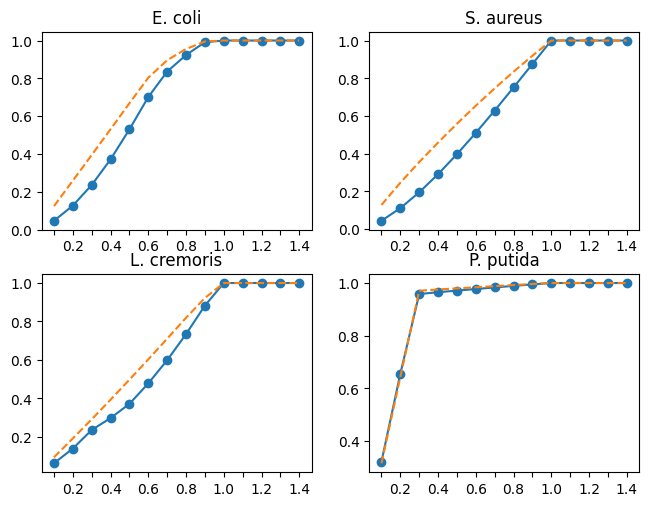

In [13]:
ex = ['ecoli','saureus','lcremoris','pputida']
fig,ax = plt.subplots(2,2,figsize = (5*1.34,5))
ax = ax.flatten()
plt.tight_layout()
for idx,org in enumerate(ex):
    plot(org,"mg2",ax=ax[idx])
    ax[idx].set_title(names[org])
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("./figures/metal_examples.svg",format="SVG")

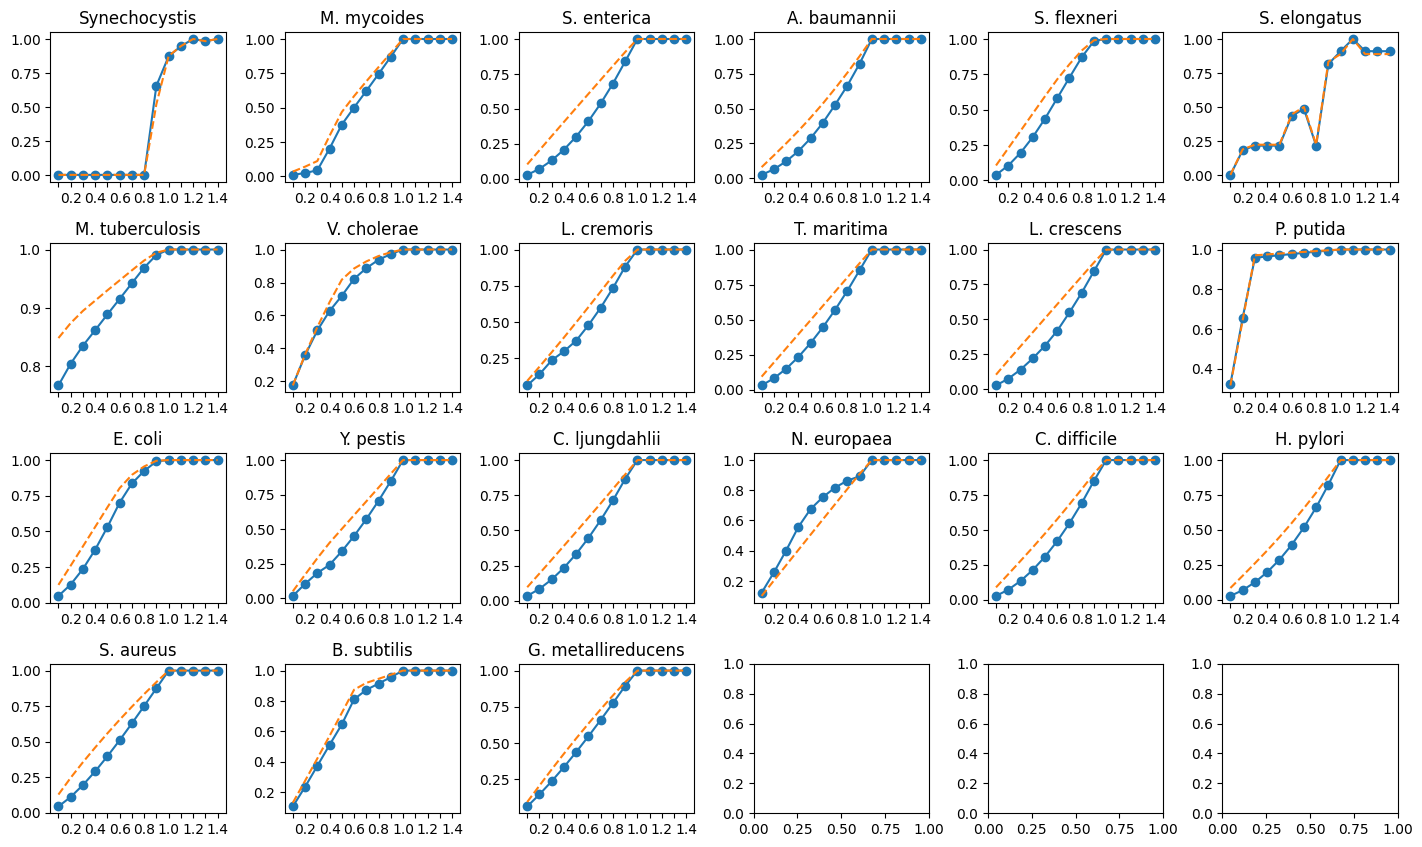

In [14]:
ex = list(models['clean'].keys())
fig,ax = plt.subplots(4,6,figsize = (20/1.4,12/1.4))
ax = ax.flatten()
plt.tight_layout
for idx,org in enumerate(ex):
    plot(org,"mg2",ax=ax[idx])
    ax[idx].set_title(names[org])
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("./figures/mg2_all.svg",format="SVG")